<a href="https://colab.research.google.com/github/yeomko22/data_analytics_camp_2023_share/blob/main/week19_deeplearning_nlp/ch19_7_test_translation_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ch19_7 번역 모델 성능 평가하기

이번 챕터에서는 번역 모델의 성능을 평가하는 방법에 대해서 알아보겠습니다.


- 이 튜토리얼에서는 이전 시간에 학습시킨 seq2seq 모델로 직접 번역을 돌려보고 성능 평가를 해봅니다.
- greedy decoding과 beam search를 직접 구현해봅니다.

## 사전 작업

### 디바이스 설정

In [38]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### 데이터 셋 불러오기

In [2]:
import pandas as pd

test_df = pd.read_csv("./drive/MyDrive/dscamp_2023/translation_test.csv")

In [3]:
test_df

,kor,eng
0,정말? 그래서 좋은 시간을 보냈니? 맛있는 것도 많이 먹었니?,really? so did you have a good time? did you e...
1,"만약 우리의 인생이 한낱 꿈에 불과하다면, 왜 우리는 모두 이렇게 욕심이 많을까요?","if our life is but a dream, why do we have an ..."
2,우리는 공항에서만 무료 와이파이를 쓸 수 있어서 게스트하우스 가는 길을 미리 찾아놨어요.,"as we could only use free wifi at the airport,..."
3,그곳에 한국에서 분차를 가장 맛있게 먹을 수 있는 곳입니다.,the place where we can enjoy the bun cha the m...
4,나는 그림을 잘 그리진 못하지만 그림 그리는 것을 좋아합니다.,i can't draw very well but i like to draw.
...,...,...
995,내가 보낸 우편물을 확인해 봤어요?,did you check the mail i sent?
996,나는 바로 유치원으로 취직을 했습니다.,i got a job at a kindergarten immediately.
997,고맙지만 도와주시지 않아도 돼요.,"thank you, but i dont need help."
998,오늘 우리 3명은 커피숍을 소개하도록 하겠습니다.,"we, three members, will introduce coffee shops..."


### tokenizer 불러오기 및 tokenize 함수 작성

In [4]:
from tokenizers import Tokenizer


kor_tokenizer = Tokenizer.from_file("./drive/MyDrive/dscamp_2023/translation_kor_tokenizer.json")
eng_tokenizer = Tokenizer.from_file("./drive/MyDrive/dscamp_2023/translation_eng_tokenizer.json")

In [36]:
vocabs = kor_tokenizer.get_vocab()
pad_token = vocabs["[PAD]"]
sos_token = vocabs["[SOS]"]
eos_token = vocabs["[EOS]"]

In [6]:
MAX_TOKENS = 256

def tokenize(text, is_korean=True):
    if is_korean:
        tokens = kor_tokenizer.encode(text).ids
    else:
        tokens = eng_tokenizer.encode(text).ids
    tokens = tokens[:MAX_TOKENS]
    token_tensor = torch.tensor(tokens, dtype=torch.long)
    return token_tensor

### 모델 불러오기

In [24]:
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class Encoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, bidirectional):
        super(Encoder, self).__init__()
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.embedding = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=embedding_dim
        )
        self.rnn = nn.GRU(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            bidirectional=bidirectional,
            dropout=0.5,
        )
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_dim * 2, hidden_dim)

    def forward(self, x, lengths):
        embedded = self.dropout(self.embedding(x))
        packed_embedded = pack_padded_sequence(embedded, lengths, enforce_sorted=False)
        padded_outputs, hidden = self.rnn(packed_embedded)
        if self.rnn.bidirectional:
            hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))
            hidden = hidden.unsqueeze(0)
        return hidden

In [25]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.GRU(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            dropout=0.5,
        )
        self.fc = nn.Linear(hidden_dim, vocab_size)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x, lengths, hidden):
        embedded = self.dropout(self.embedding(x))
        packed_embedded = pack_padded_sequence(embedded, lengths, enforce_sorted=False)

        # rnn 호출 시에 encoder로부터 전달받은 hidden, cell을 넣어주면 됩니다.
        packed_output, hidden = self.rnn(packed_embedded, hidden)
        outputs, output_lengths = pad_packed_sequence(packed_output)
        prediction = self.dropout(self.fc(outputs))
        return prediction, hidden

In [26]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, src_padded, src_lengths, tar_in_padded, tar_lengths):
        hidden = self.encoder(src_padded, src_lengths)
        prediction, hidden = self.decoder(tar_in_padded, tar_lengths, hidden)
        return prediction

In [27]:
VOCAB_SIZE = 8000
EMBEDDING_DIM = 256
HIDDEN_UNITS = 256
EMBED_MAX_NORM = 1
NUM_LAYERS = 1
DROPOUT = 0.5
BIDIRECTIONAL = True

In [28]:
encoder = Encoder(
    vocab_size=VOCAB_SIZE,
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=HIDDEN_UNITS,
    num_layers=NUM_LAYERS,
    bidirectional=BIDIRECTIONAL
)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [29]:
decoder = Decoder(
    vocab_size=VOCAB_SIZE,
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=HIDDEN_UNITS,
    num_layers=NUM_LAYERS,
)

In [30]:
model = Seq2Seq(encoder, decoder)

In [32]:
weight_path = "./drive/MyDrive/dscamp_2023/translation_weight.pth"
weight = torch.load(weight_path)

In [33]:
model.load_state_dict(weight)

<All keys matched successfully>

In [39]:
model = model.to(device)

In [17]:
!pip install torchinfo

In [40]:
from torchinfo import summary

summary(model)

Layer (type:depth-idx)                   Param #
Seq2Seq                                  --
├─Encoder: 1-1                           --
│    └─Embedding: 2-1                    2,048,000
│    └─GRU: 2-2                          789,504
│    └─Dropout: 2-3                      --
│    └─Linear: 2-4                       131,328
├─Decoder: 1-2                           --
│    └─Embedding: 2-5                    2,048,000
│    └─GRU: 2-6                          394,752
│    └─Linear: 2-7                       2,056,000
│    └─Dropout: 2-8                      --
Total params: 7,467,584
Trainable params: 7,467,584
Non-trainable params: 0

### Greedy Decoding

In [41]:
MAX_SEQUENCE_LENGTH = 30

def greedy_decoding(model, sentence):
    model.eval()
    tokens = tokenize(sentence, is_korean=True)
    src_in = tokens.unsqueeze(-1).to(device)
    src_lengths = [len(tokens)]
    tar_in = torch.tensor([[sos_token]], dtype=torch.long).to(device)
    tar_lengths = [1]

    with torch.no_grad():
        hidden = model.encoder(src_in, src_lengths)
        results = []
        for i in range(MAX_SEQUENCE_LENGTH):
            prediction, hidden = model.decoder(tar_in, tar_lengths, hidden)
            # sequence length, batch size 모두 1이므로 의미 없는 차원 제거
            prediction = prediction.squeeze()
            # top1 예측 결과 저장 및 EOS 토큰일 경우 인퍼런스 중지
            top1 = prediction.argmax()
            results.append(top1.item())
            if top1 == eos_token:
                break
            # 이전 시점의 출력값을 다음 시점의 입력 값으로 사용
            tar_in = torch.tensor([[top1]], dtype=torch.long).to(device)
    translated = eng_tokenizer.decode(results)
    return translated

In [45]:
greedy_decoding(model, "만나서 반갑고, 앞으로 잘부탁한다!")

"nice to meet you , and i ' m glad to meet you !"

## 번역 모델 성능 측정

번역 모델의 성능은 단순히 accuracy로 평가할 수 없습니다. 하나의 문장이 여러 문장으로 번역될 수 있고, 어순이 조금 달라지더라도 맞는 번역일 수 있기 때문입니다. 예를 들어보겠습니다.

- 예시 입력: 만나서 반갑습니다.
- 라벨: nice to meet you.
- 번역 1: nice to meet you.
- 번역 2: I'm glad to meet you.

번역 1과 2 모두 맞는 번역임에도 불구하고 라벨과 비교해보면 번역 2는 완전히 잘못된 번역이라는 결과가 나옵니다. 이러한 번역 테스크의 특징을 잘 고려해주는 것이 bleu score입니다. bleu score의 세부적인 내용이 궁금하신 분들은 아래 문서를 참고해주세요.

https://wikidocs.net/31695

bleu score를 측정할 때에는 보통 시퀀스의 길이에 따라서 score를 측정한 다음, 이를 그래프로 시각화 합니다. 예를들어 길이가 20 이하인 문장들만 번역한 결과 정확도를 측정하고, 30 이하인 문장들 번역 정확도를 측정하는 식입니다.

시퀀스 길이를 변경해가며, bleu score를 측정해보겠습니다.

### 테스트 데이터 셋 번역

greedy decoding 방식으로 테스트 데이터 셋을 번역해서 결과를 기록해보겠습니다.

In [47]:
import csv
from tqdm.notebook import tqdm

output_path = "./drive/MyDrive/dscamp_2023/test_translated.csv"
with open(output_path, "w") as fw:
    writer = csv.writer(fw)
    writer.writerow(["kor", "eng", "translated"])
    for i in tqdm(range(len(test_df))):
        row = test_df.iloc[i]
        kor = row["kor"]
        eng = row["eng"]
        translated = greedy_decoding(model, kor)
        writer.writerow([kor, eng, translated])

  0%|          | 0/1000 [00:00<?, ?it/s]

### bleu Score 계산

토큰 길이 수에 따른 blue_score 계산 후, 플랏을 그려보겠습니다.

In [48]:
from torchtext.data.metrics import bleu_score

In [49]:
translated_df = pd.read_csv(output_path)

In [53]:
candidate_corpus = []
reference_corpus = []

corpus = []

for i in range(len(translated_df)):
    row = translated_df.iloc[i]
    kor = row["kor"]
    eng = row["eng"]
    translated = row["translated"]
    reference_tokens = eng_tokenizer.encode(eng).tokens
    candidate_tokens = eng_tokenizer.encode(translated).tokens
    ref_len = len(reference_tokens)
    corpus.append((ref_len, reference_tokens, candidate_tokens))

In [54]:
corpus = sorted(corpus, key=lambda x: x[0])

In [60]:
import numpy as np


bleu_scores = []
intervals = np.arange(10, 45, 5)
for interval in tqdm(intervals):
    last_idx = 0
    for i, (ref_len, _, _) in enumerate(corpus):
        last_idx = i
        if ref_len > interval:
            break
    reference_corpus = [[x[1]] for x in corpus[:last_idx]]
    candidate_corpus = [x[2] for x in corpus[:last_idx]]
    score = bleu_score(candidate_corpus, reference_corpus)
    bleu_scores.append(score)

  0%|          | 0/7 [00:00<?, ?it/s]

In [61]:
bleu_scores

[0.13383258879184723,
 0.12161616823884622,
 0.10888072174902194,
 0.10286813766805454,
 0.09979911158794622,
 0.0983109125530399,
 0.09785576465590201]

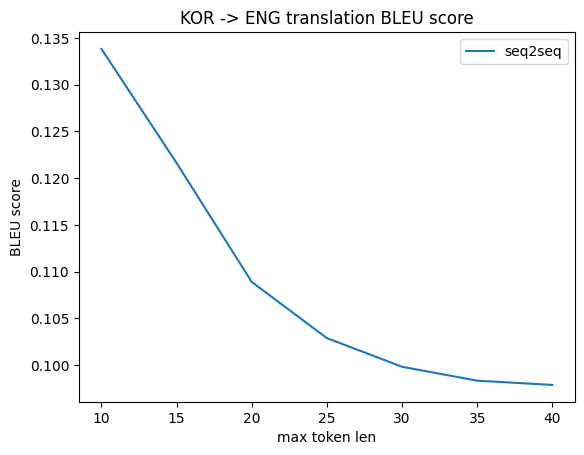

In [62]:
from matplotlib import pyplot as plt
import numpy as np

intervals = np.arange(10, 45, 5)
plt.plot(intervals, bleu_scores, label="seq2seq")
plt.xlabel("max token len")
plt.ylabel("BLEU score")
plt.title("KOR -> ENG translation BLEU score")
plt.legend()

## 정리

이번 챕터에서는 기계 번역 모델의 성능을 측정하는 bleu score에 대해서 알아보았습니다. 이 외에 자연어 처리 분야에는 모델의 성능을 측정하는 지표들이 다양하게 존재합니다. 모델과 데이터에 맞게 지표를 선택한다는 점만 기억하고 넘어가겠습니다.